# Seleção de Atributo com base no Ganho de Informação

O ganho de informação (GI) é uma medida que indica o quão informativo é um atributo com relação a separação das classes alvo. A estratégia de seleção de atributos baseada em GI utiliza a entropia como peça fundamental na medição de desordem dos conjuntos. Quanto menor as entropias dos subconjuntos filhos em relação a entropia do conjunto pai, então maior é o ganho de informação oferecido pelo atributo que gerou a divisão.

In [88]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')

## Descrição do dataset mushrooms

O dataset *mushroom* pertence ao bem conhecido repositório de dados da Universidade da Califórnia, em Irvine, e trata de uma série de descrições acerca de diversos tipos de cogumelos. Os atributos deste conjunto de dados variam entre formato, odor, cor, habitat, etc. totalizando 22 diferentes informações sobre as características dos cogumelos. Cada uma das 8124 amostras é classificada como comestível ou venenosa, sendo este o 23º atributo, o atributo alvo.
Fonte: http://archive.ics.uci.edu/ml/datasets/Mushroom

In [89]:
mushrooms = pd.read_csv('mushrooms.csv')
print('Total de linhas = {}\nTotal de colunas = {}'.format(mushrooms.shape[0], mushrooms.shape[1]))

Total de linhas = 8124
Total de colunas = 23


In [90]:
mushrooms.head()   # As 5 primeiras amostras de cogumelos do dataset

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Por questões de facilidade de armmazenamento, os valores assumidos por cada coluna estão codificados em um único caractere. A tabela abaixo fornece a decodificação para fins de esclarecimento.


| Nome do atributo | Possíveis valores |
| :-- | :-- |
| **class** | **e=edible, p=poisonous** |
| cap-shape | b=bell, c=conical, x=convex, f=flat, k=knobbed, s=sunken=s |
| cap-surface | f=fibrous, g=grooves, y=scaly, s=smooth |
| cap-color | n=brown, b=buff, c=cinnamon, g=gray, r=green, p=pink, u=purple, e=red, w=white, y=yellow |
| bruises | t=bruises, f=no |
| odor | a=almond, l=anise, c=creosote, y=fishy, f=foul, m=musty, n=none, p=pungent, s=spicy |
| gill-attachment | a=attached, d=descending, f=free, n=notched |
| gill-spacing | c=close, w=crowded, d=distant |
| gill-size | b=broad, n=narrow |
| gill-color | k=black, n=brown, b=buff, h=chocolate, g=gray, r=green, o=orange, p=pink, u=purple, e=red, w=white, y=yellow |
| stalk-shape | e=enlarging, t=tapering |
| stalk-root | b=bulbous, c=club, u=cup, e=equal, r=rhizomorphs, r=rooted, ?=missing |
| stalk-surface-above-ring | f=fibrous, y=scaly, k=silky, s=smooth |
| stalk-surface-below-ring | f=fibrous, y=scaly, k=silky, s=smooth |
| stalk-color-above-ring | n=brown, b=buff, c=cinnamon, g=gray, o=orange, p=pink, e=red, w=white, y=yellow |
| stalk-color-below-ring | n=brown, b=buff, c=cinnamon, g=gray, o=orange, p=pink, e=red, w=white, y=yellow |
| veil-type | p=partial, u=universal |
| veil-color | n=brown, o=orange, w=white, y=yellow |
| ring-number | n=none, o=one, t=two |
| ring-type | c=cobwebby, e=evanescent, f=flaring, l=large, n=none, p=pendant, s=sheathing, z=zone |
| spore-print-color | k=black, n=brown, b=buff, h=chocolate, r=green, o=orange, u=purple, w=white, y=yellow |
| population | a=abundant, c=clustered, n=numerous, s=scattered, v=several, y=solitary |
| habitat| g=grasses, l=leaves, m=meadows, p=paths, u=urban, w=waste, d=woods |

In [91]:
mushrooms.isna().sum()     # quantidade de dados não valorados (NaN) por coluna

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

O dataset está livre de dados não valorados, então podemos seguir em frente sem que seja necessário um tratamento neste sentido.

## Entropia

A entropia é uma medida que quantifica a desordem  dos elementos de um conjunto. Em nossos problemas de extração de características a partir de dados, desejamos que os elementos de um mesmo conjunto compartilhem características comuns. Ou em outras palavras, queremos que as amostras de um mesmo conjunto pertençam a mesma classe.

A seguir seque a fórmula geral para a entropia de um conjunto com base em $n$ classes:

$$ \text{entropia} = -p_1\cdot \log_2(p_1) - p_2\cdot \log_2(p_2) - \text{ ... } - p_n \cdot \log_2(p_n) $$

> entropia: entropia do conjunto <br>
$p_1$: proporção de amostras da classe 1 <br>
$p_2$: proporção de amostras da classe 2 <br>
$p_n$: proporção de amostras da classe $n$ <br>
$\log_2()$: logaritmo na base 2

Considere os exemplos abaixo. Ambos os conjuntos representam configurações compostas por 2 diferentes classes: triângulo e xis.
![title](entropia_ex1.png)
* O conjunto A possui 9 amostras, sendo 5 da classe triângulo e 4 da classe xis. Essa configuração exprime a ideia de altíssima desordem ou entropia.
* Já o conjunto B possui 3 amostras, sendo todas da classe triângulo e nenhuma da classe xis. Aqui se configura um caso de entropia zero ou desordem mínima.

In [92]:
def entropy(target):
    '''    
    Retorna a entropia de um conjunto.

    Parâmetros:
        target (pandas.Series): Uma série com os rótulos de classe para cada amostra do conjunto.

    Retorno:
        entropy (float): A entropia do conjunto.   
    '''
    n_rows = len(target)
    entropy = 0
    
    for c in target.unique():
        n_rows_c = len(target[target==c])
        proportion = n_rows_c / n_rows
        
        if(proportion != 0):
            entropy -= proportion * np.log2(proportion)
        
    return entropy

Em relação ao dataset *mushroom* vamos calcular a entropia raiz, ou seja, a desordem de todo o conjunto de 8124 amostras disponíveis. Assim como no exemplo, nosso problema se resume a 2 classes, mas dessa vez sendo *e = edible* (comestível) e *p = poisonous* (venenoso). Utilizaremos a função definida acima e passaremos como parâmetro, *mushrooms['class']*, a coluna que contém os rótulos de classe de todas as amostras.

In [93]:
entropy_root = entropy(mushrooms['class'])    # calculando a entropia raíz
print('Entropia raiz = {}'.format(entropy_root))

Entropia raiz = 0.9990678968724603


In [94]:
print('Quantidade total de amostras por classe: \n Comestível = {} \n Venenoso = {}'
      .format(len(mushrooms[mushrooms['class']=='e']), 
              len(mushrooms[mushrooms['class']=='p'])))

Quantidade total de amostras por classe: 
 Comestível = 4208 
 Venenoso = 3916


## Ganho de Informação

Utilizamos o ganho de informação para medir o quanto um atributo é capaz de diminuir a entropia de um conjunto. Pode ser visto como uma função dos graus de desordem do conjunto pai e dos conjuntos filhos resultantes da divisão. Quanta informação determinado atributo é capaz de trazer visando a plena separação das classes?

![title](entropia_ex2.png)

A fóruma geral do ganho de informação é dada por:

$$ GI = \text{entropia}(\text{pai})-r_1 \cdot \text{entropia}(\text{filho}_1)-r_2 \cdot \text{entropia}(\text{filho}_2) - \text{ ... } - r_n \cdot \text{entropia}(\text{filho}_n)$$

> GI: ganho de informação <br>
entropia(pai): entropia do conjunto pai <br>
entropia(filho$_1$): entropia do subconjunto filho$_1$ <br>
entropia(filho$_2$): entropia do subconjunto filho$_2$ <br>
entropia(filho$_n$): entropia do subconjunto filho$_n$ <br>
$r_1$: razão entre o nº de amostras do subconjunto filho 1 e o nº de amostras do conjunto pai <br>
$r_2$: razão entre o nº de amostras do subconjunto filho 2 e o nº de amostras do conjunto pai <br>
$r_n$: razão entre o nº de amostras do subconjunto filho $n$ e o nº de amostras do conjunto pai

Para o exemplo, temos que o ganho de  informação do atributo *Escolaridade* é igual a:

$$ GI = 0.92 - \frac{9}{12}\cdot0.99 - \frac{3}{12}\cdot 0 = 0.1775 $$ 

In [95]:
def informationGain(attribute, target):
    '''    
    Retorna o ganho de informação oferecido por determinado atributo.

    Parâmetros:
        attribute (pandas.Series): Uma série com os valores do atributo para cada amostra do conjunto.
        target (pandas.Series): Uma série com os rótulos de classe para cada amostra do conjunto.

    Retorno:
        information_gain (float): O ganho de informação obtido.   
    '''
    n_rows = len(target)
    information_gain = entropy(target)

    for label in attribute.unique():
        n_rows_label = len(attribute[attribute==label])
        ratio = n_rows_label / n_rows

        information_gain -= ratio * entropy(target[attribute==label])

    return information_gain

Voltando ao estudo dos dados de cogumelos, agora iremos quantificar o ganho de informação oferecido por cada um dos 22 atributos. O conjunto pai será todo o dataset, e ao analisar cada atributo por vez serão gerados os subconjuntos filhos correspondentes. Já sabemos a entropia do conjunto pai que neste caso é exatamente igual a entropia raiz = 0.999. Utilizaremos a função *informationGain* definida acima para encontrar todas as 22 medidas de ganho de informação ordenadas em ordem decrescente. 

In [96]:
index = mushrooms.drop(columns='class').columns
IG_atts = [informationGain(mushrooms[att], mushrooms['class']) for att in index]
IG = pd.DataFrame(index=index, data={'Ganho de Informação': IG_atts})
IG.sort_values('Ganho de Informação', ascending=False)

,Ganho de Informação
odor,0.906075
spore-print-color,0.480705
gill-color,0.416978
ring-type,0.318022
stalk-surface-above-ring,0.284726
stalk-surface-below-ring,0.271894
stalk-color-above-ring,0.253845
stalk-color-below-ring,0.241416
gill-size,0.230154
population,0.201958


O atributo *odor* se destaca como o atributo que oferece o maior ganho de informação. Isso significa que os subconjuntos  formados por cogumelos com o mesmo *odor* geralmente também pertencem a mesma classe, auxliando na separação entre comestíveis e venenosos. Como revelado anteriormente, tal atributo pode assumir 9 possíveis valores, sendo: 

|odor | a | l | c | y | f | m |n | p | s|
|-- | -- |-- |--|--|--|--|--|--|--|
| | almond | anise | creosote | fishy | faul | musty | none | pungent | spicy|

Para justificar o porquê do alto ganho de informação, investigaremos a entropia dos 9 subconjuntos.

In [97]:
print('Odor   Entropia')
for label in mushrooms['odor'].unique():
    print(label, '    ', entropy(mushrooms[mushrooms['odor']==label]['class']))

Odor   Entropia
p      0.0
a      0.0
l      0.0
n      0.2141367567812511
f      0.0
c      0.0
y      0.0
s      0.0
m      0.0


Com exceção do *odor* *n = none* (sem cheiro) todos os outros são subconjuntos puros, possuem apenas cogumelos de 1 das classes. Podemos concluir que se um cogumelo emite algum cheiro, então estaremos confiantes em classificá-lo na classe dos comestíveis ou na classe dos venenosos. Para ajudar ainda mais na compreensão, podemos encontrar a quantidade de cogumelos por *odor* emitido e qual a classe predominante nestes subconjuntos.

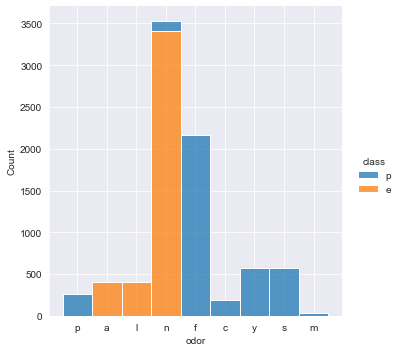

In [98]:
sns.displot(data=mushrooms, x='odor', hue='class', multiple='stack');

Se nos for apresentado um novo cogumelo desconhecido que possui cheiro, então podemos classificá-lo com 100% de probabilidade como:
* venenoso (*p = poisonous*) se seu *odor* for do tipo *p = pungent*, *f = faul*, *c = creosote*, *y = fishy*, *s = spicy* ou *m = musty*;
* comestível (*e = edible*) se seu *odor* for do tipo *a = almond*, *l = anise*.

Porém se ele não emitir qualquer tipo de cheiro (*n = none*), teremos um forte indício de 96.6% de chance de que seja comestível, você arriscaria?

In [99]:
prob = len(mushrooms[(mushrooms['odor']=='n') & (mushrooms['class']=='e')]) / len(mushrooms[mushrooms['odor']=='n'])
print('Probabilidade de um cogumelo sem cheiro ser comestível =', prob)

Probabilidade de um cogumelo sem cheiro ser comestível = 0.9659863945578231
